In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 11.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as img

import cv2
import itertools
import pathlib
import warnings
from PIL import Image
from random import randint
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from keras import layers
import tensorflow as tf
import tensorflow_addons as tfa

from collections import Counter

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, Concatenate, Conv2D, Flatten, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

from tensorflow.keras.models import Model
from distutils.dir_util import copy_tree, remove_tree

from imblearn.combine import SMOTETomek

import os
print(os.listdir("/content/drive/MyDrive/archive/Dataset"))

print("TensorFlow Version:", tf.__version__)

['Very_Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Mild_Demented']
TensorFlow Version: 2.12.0


In [ ]:
X, y = [], []

## Images rescaling
datagen = ImageDataGenerator(rescale=1.0/255.0)

#   Load images by resizing and shuffling randomly
train_dataset = datagen.flow_from_directory("/content/drive/MyDrive/archive/Dataset", target_size=(128, 128),batch_size=6400, shuffle=True)

### Seperate Dataset from  Data Genrator
X, y = train_dataset.next()

Found 6430 images belonging to 4 classes.


In [ ]:
samples_before = len(X)
print("Images shape :\t", X.shape)
print("Labels shape :\t", y.shape)

Images shape :	 (6400, 128, 128, 3)
Labels shape :	 (6400, 4)


In [ ]:
#   Number of samples in classes
print("Number of samples in each class:\t", sorted(Counter(np.argmax(y, axis=1)).items()))

#   class labels as per indices
print("Classes Names according to index:\t", train_dataset.class_indices)

Number of samples in each class:	 [(0, 894), (1, 64), (2, 3214), (3, 2228)]
Classes Names according to index:	 {'Mild_Demented': 0, 'Moderate_Demented': 1, 'Non_Demented': 2, 'Very_Mild_Demented': 3}


In [ ]:
##random figures.

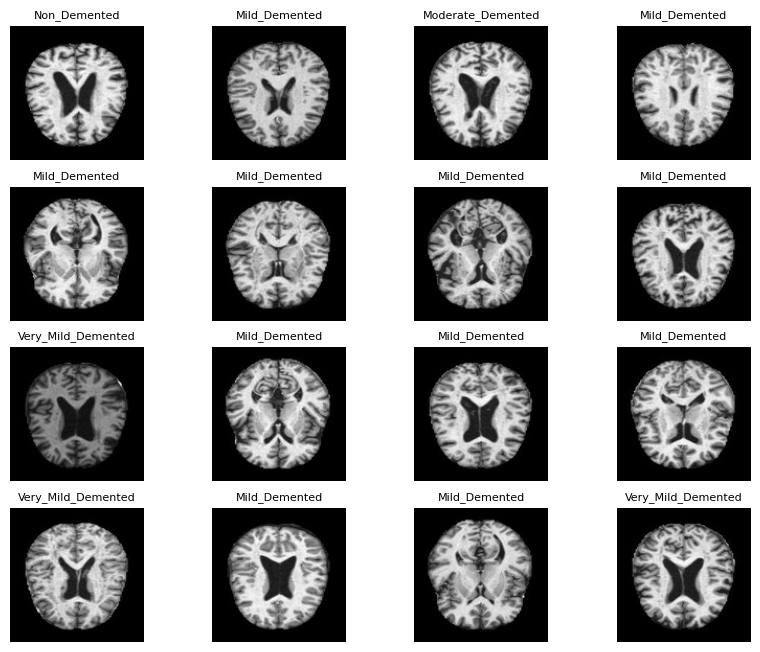

In [ ]:
#   show some samples from the dataset randomly
import random
fig = plt.figure(figsize=(10,8))

CLASSES=['Non_Demented', 'Moderate_Demented', 'Mild_Demented', 'Very_Mild_Demented']

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(0, len(X)-1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

In [ ]:
#   reshaping the images to 1D
X = X.reshape(-1, 128 * 128 * 3)

#   Oversampling method to remove imbalance class problem
X, y = SMOTETomek().fit_resample(X, y)

#   reshape images to images size of 208, 176, 3
X = X.reshape(-1, 128, 128, 3)

samples_after = len(X)
print("Number of samples after SMOTETomek :\t", sorted(Counter(np.argmax(y, axis=1)).items()))

Number of samples after SMOTETomek :	 [(0, 3214), (1, 3214), (2, 3214), (3, 3214)]


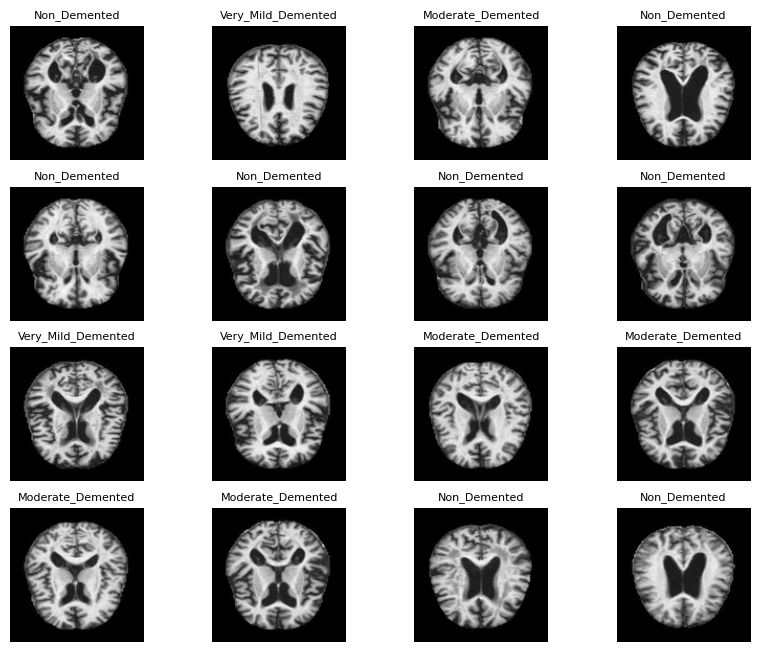

In [ ]:
fig = plt.figure(figsize=(10,8))

rows = 4
columns = 4

for i in range(rows * columns):
    fig.add_subplot(rows, columns, i+1)
    num = random.randint(samples_before, samples_after - 1 )
    plt.imshow(X[num])
    plt.axis('off')
    plt.title(CLASSES[(np.argmax(y[num]))], fontsize=8)
plt.axis('off')
plt.show()

In [ ]:
## sliplitting

In [ ]:
#   20% split to validation and 80% split to train set
X_train, x_val, y_train, y_val = train_test_split(X,y, test_size = 0.2)

#   20% split to test from 80% of train and 60% remains in train set
X_train, x_test, y_train, y_test = train_test_split(X_train,y_train, test_size = 0.2)

# Number of samples after train test split
print("Number of samples after splitting into Training, validation & test set\n")

print("Train     \t",sorted(Counter(np.argmax(y_train, axis=1)).items()))
print("Validation\t",sorted(Counter(np.argmax(y_val, axis=1)).items()))
print("Test      \t",sorted(Counter(np.argmax(y_test, axis=1)).items()))

Number of samples after splitting into Training, validation & test set

Train     	 [(0, 2047), (1, 2044), (2, 2033), (3, 2103)]
Validation	 [(0, 643), (1, 627), (2, 665), (3, 637)]
Test      	 [(0, 524), (1, 543), (2, 516), (3, 474)]


In [ ]:
#   to free memeory we don't need this one as we split our data
del X, y

In [ ]:
def dense_block(x, blocks, growth_rate):
    for _ in range(blocks):
        # Convolutional layer
        y = Conv2D(growth_rate, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        # Concatenate feature maps
        x = Concatenate()([x, y])
    return x

# Input layer
inputs = Input(shape=(128,128, 3))
x = inputs


# Block 1
x = Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)  # Dropout after the MaxPooling2D layer

# Block 2
x = dense_block(x, 2, 32)  # Dense block with 2 layers and growth rate of 32
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)  # Dropout after the MaxPooling2D layer

# Block 3
x = dense_block(x, 3, 64)  # Dense block with 3 layers and growth rate of 64
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.25)(x)  # Dropout after the MaxPooling2D layer

# Flatten
x = Flatten()(x)

# Dense layers
x = Dense(128, activation='relu', kernel_initializer='he_normal')(x)
x = Dense(64, activation='relu')(x)

# Output layer
outputs = Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=inputs, outputs=outputs)


In [ ]:
### Model Compilation

model.compile(
    optimizer="Adam",
    loss = tf.keras.losses.CategoricalCrossentropy(name='loss'),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name='acc'),
        tf.keras.metrics.AUC(name='auc'),
        tfa.metrics.F1Score(num_classes=4),
        tf.metrics.Precision(name="precision"),
        tf.metrics.Recall(name="recall") ])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 64, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                              

In [ ]:
#   declare to run on small gpu create batch sizes of images
valAug = ImageDataGenerator()

hist = model.fit(valAug.flow(X_train, y_train, batch_size=64, shuffle = True),
steps_per_epoch=len(X_train)  // 80,
validation_data=valAug.flow(x_val, y_val, batch_size=64, shuffle = True),
validation_steps=len(x_test) //80,
epochs= 10,
batch_size=64,
)

Epoch 1/10
102/102 [==============================] - 354s 3s/step - loss: 0.0321 - acc: 0.9875 - auc: 0.9997 - f1_score: 0.9877 - precision: 0.9877 - recall: 0.9871 - val_loss: 0.0352 - val_acc: 0.9862 - val_auc: 0.9998 - val_f1_score: 0.9866 - val_precision: 0.9869 - val_recall: 0.9856
Epoch 2/10
102/102 [==============================] - 351s 3s/step - loss: 0.0245 - acc: 0.9915 - auc: 0.9997 - f1_score: 0.9915 - precision: 0.9917 - recall: 0.9908 - val_loss: 0.0227 - val_acc: 0.9912 - val_auc: 0.9999 - val_f1_score: 0.9912 - val_precision: 0.9919 - val_recall: 0.9900
Epoch 3/10
102/102 [==============================] - 350s 3s/step - loss: 0.0377 - acc: 0.9858 - auc: 0.9996 - f1_score: 0.9859 - precision: 0.9863 - recall: 0.9855 - val_loss: 0.0362 - val_acc: 0.9881 - val_auc: 0.9998 - val_f1_score: 0.9883 - val_precision: 0.9894 - val_recall: 0.9881
Epoch 4/10
102/102 [==============================] - 356s 3s/step - loss: 0.0284 - acc: 0.9905 - auc: 0.9997 - f1_score: 0.9905 - pr

In [ ]:
model.save("/content/drive/MyDrive/archive/model_f.h5")

In [ ]:
### Evaluate Model
test_scores = model.evaluate(x_test, y_test, batch_size = 32)


print("\n\nTesting Loss : \t\t {0:0.6f}".format(test_scores[0] ))
print("Testing Accuracy : \t {0:0.6f} %".format(test_scores[1] * 100))
print("Testing AC : \t\t {0:0.6f} %".format(test_scores[2] * 100))
print("Testing F1-Score : \t {0:0.6f} %".format(((test_scores[3][0] + test_scores[3][1] + test_scores[3][2] + test_scores[3][3])/4) * 100))
print("Testing Precision : \t {0:0.6f} %".format(test_scores[4] * 100))
print("Testing Recall : \t {0:0.6f} %".format(test_scores[5] * 100))

65/65 [==============================] - 25s 388ms/step - loss: 0.0221 - acc: 0.9937 - auc: 0.9994 - f1_score: 0.9934 - precision: 0.9937 - recall: 0.9922


Testing Loss : 		 0.022055
Testing Accuracy : 	 99.368012 %
Testing AC : 		 99.941486 %
Testing F1-Score : 	 99.344635 %
Testing Precision : 	 99.367088 %
Testing Recall : 	 99.222165 %


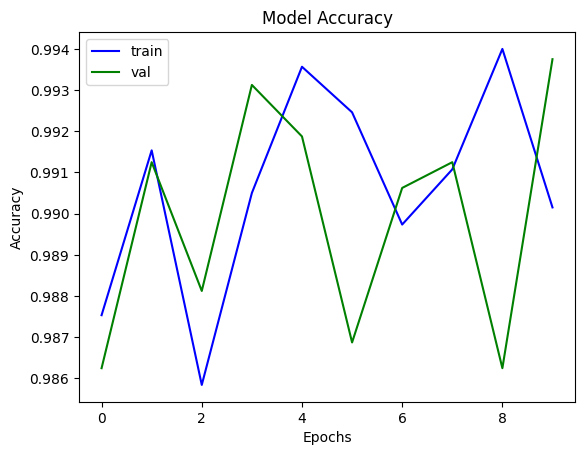

In [ ]:
plt.plot(hist.history['acc'], 'b')
plt.plot(hist.history['val_acc'], 'g')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["train", "val"])
plt.show()

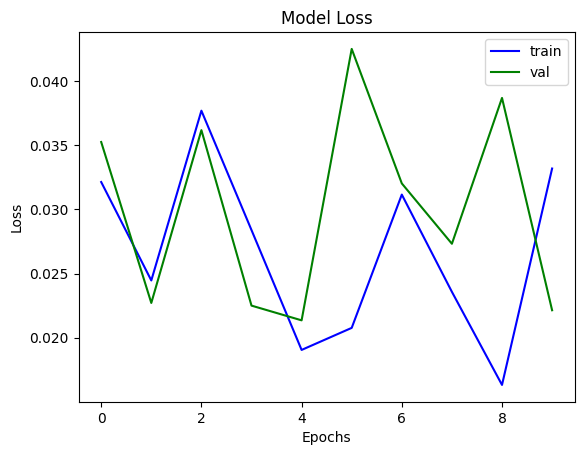

In [ ]:
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['val_loss'], 'g')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["train", "val"])
plt.show()

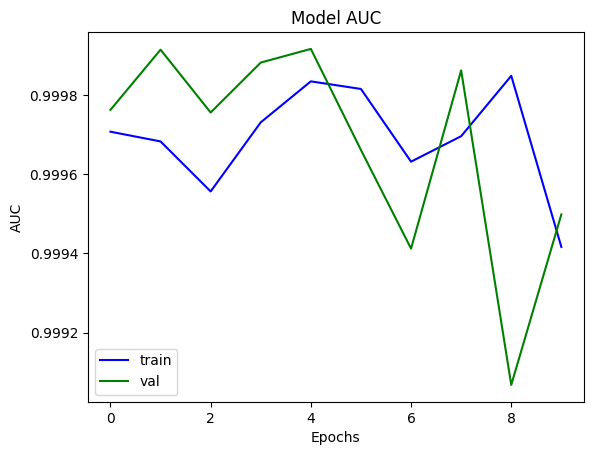

In [ ]:
plt.plot(hist.history['auc'], 'b')
plt.plot(hist.history['val_auc'], 'g')
plt.title("Model AUC")
plt.xlabel("Epochs")
plt.ylabel("AUC")
plt.legend(["train", "val"])
plt.show()

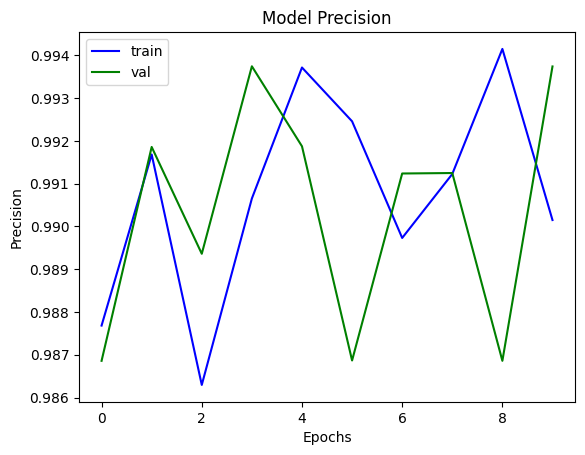

In [ ]:
plt.plot(hist.history['precision'], 'b')
plt.plot(hist.history['val_precision'], 'g')
plt.title("Model Precision")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend(["train", "val"])
plt.show()

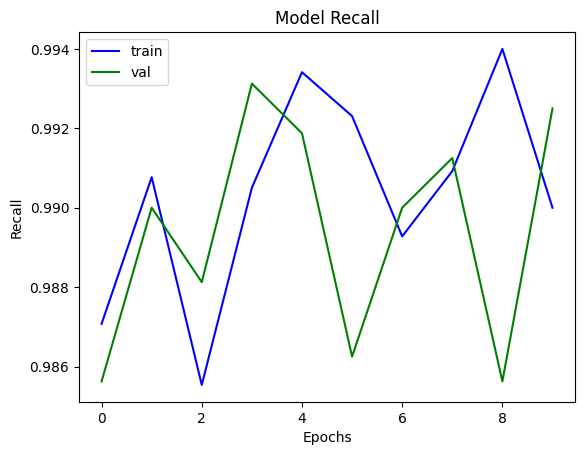

In [ ]:
plt.plot(hist.history['recall'], 'b')
plt.plot(hist.history['val_recall'], 'g')
plt.title("Model Recall")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.legend(["train", "val"])
plt.show()

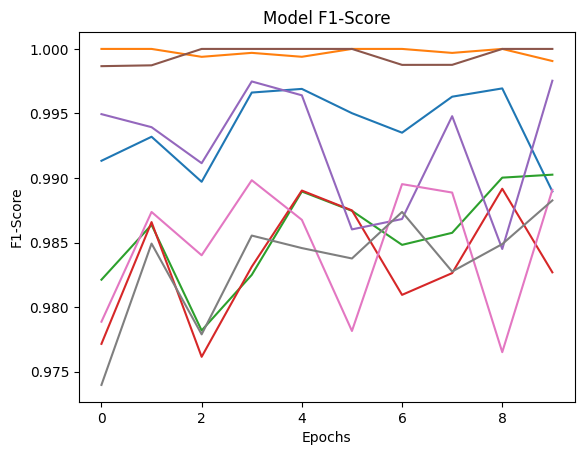

In [ ]:
plt.plot(hist.history['f1_score'])
plt.plot(hist.history['val_f1_score'])
plt.title("Model F1-Score")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

In [ ]:
pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(y_test, pred_labels, target_names=CLASSES))

65/65 [==============================] - 25s 391ms/step
                    precision    recall  f1-score   support

      Non_Demented       1.00      1.00      1.00       524
 Moderate_Demented       1.00      1.00      1.00       543
     Mild_Demented       0.99      0.98      0.99       516
Very_Mild_Demented       0.98      0.99      0.99       474

         micro avg       0.99      0.99      0.99      2057
         macro avg       0.99      0.99      0.99      2057
      weighted avg       0.99      0.99      0.99      2057
       samples avg       0.99      0.99      0.99      2057



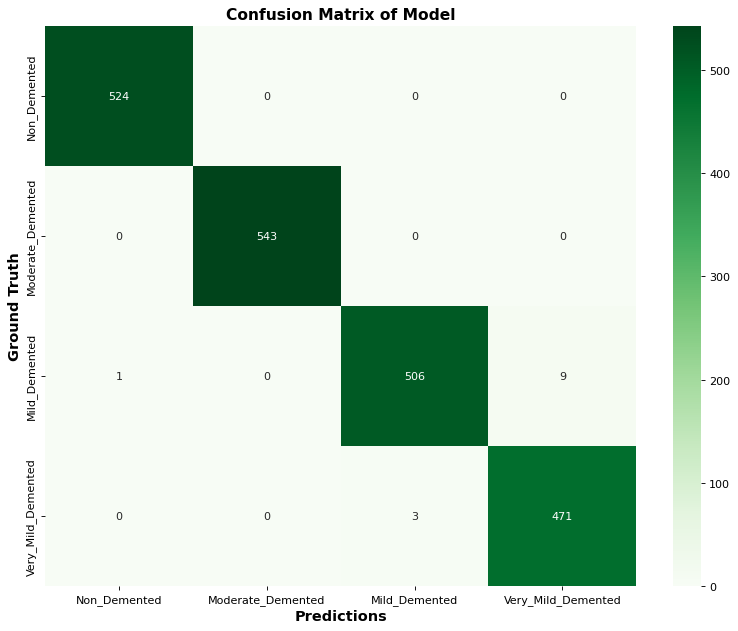

In [ ]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES, yticklabels=CLASSES)

plt.title('Confusion Matrix of Model', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

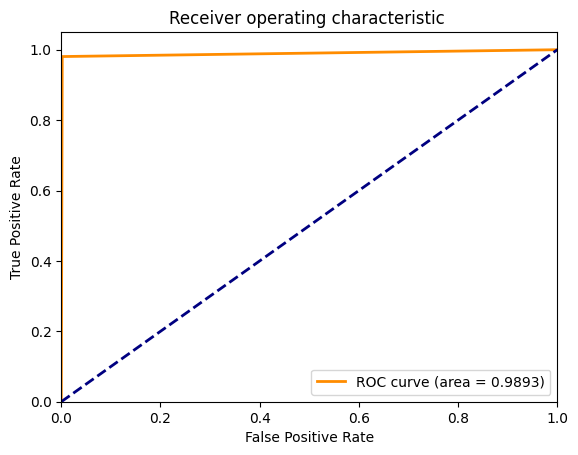

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_labels[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_labels.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.4f)" % roc_auc[2])

plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic ")
plt.legend(loc="lower right")
plt.show()

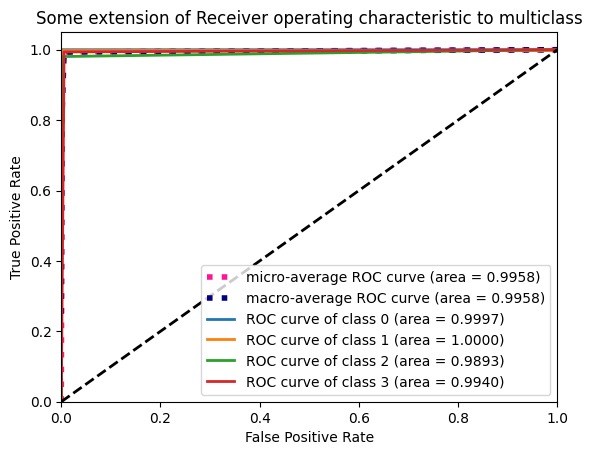

In [ ]:

n_classes = 4
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.4f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.4f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

for i in range(n_classes):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.4f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

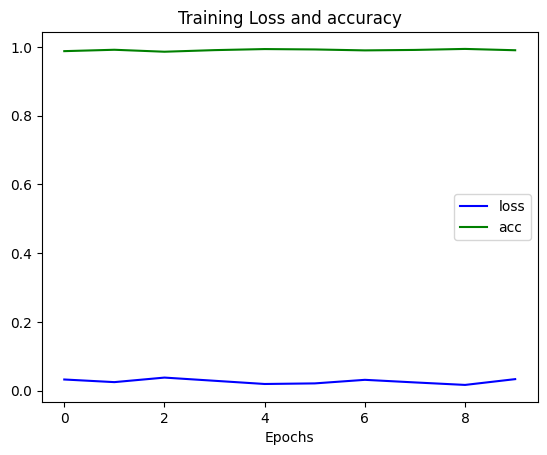

In [ ]:
plt.plot(hist.history['loss'], 'b')
plt.plot(hist.history['acc'], 'g')
plt.title("Training Loss and accuracy")
plt.xlabel("Epochs")
plt.legend(["loss", "acc"])
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/archive/final_model.h5")

In [ ]:
from sklearn.metrics import accuracy_score

pred_labels = model.predict(x_test, batch_size=32)

def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

# Convert one-hot encoded predictions to integer labels
y_pred_labels = np.argmax(pred_labels, axis=1)

# Convert one-hot encoded ground truth labels to integer labels
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(y_true_labels, y_pred_labels, target_names=CLASSES))
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print("Accuracy:", accuracy)


65/65 [==============================] - 25s 390ms/step
                    precision    recall  f1-score   support

      Non_Demented       1.00      1.00      1.00       524
 Moderate_Demented       1.00      1.00      1.00       543
     Mild_Demented       0.99      0.98      0.99       516
Very_Mild_Demented       0.98      0.99      0.99       474

          accuracy                           0.99      2057
         macro avg       0.99      0.99      0.99      2057
      weighted avg       0.99      0.99      0.99      2057

Accuracy: 0.9936801166747691


In [ ]:
model.save_weights('/content/drive/MyDrive/archive/Weights_AD_Model.hdf5')